# **Training HRPlane Dataset with YOLOv9e: Experiment No. 58.4**

<p align="center">
    <img src="https://github.com/RSandAI/Comprehensive-YOLO-Airplane-Detection/blob/main/assets/image.png" height=450 width=1280 alt=""/>
</p>

<small>Picture Source: <a href="https://github.com/RSandAI/Comprehensive-YOLO-Airplane-Detection/">RSandAI, Comprehensive YOLO Airplane Detection</a></small>

<br>

## **Context**

The HRPlanes dataset is a valuable resource in the domain of computer vision, particularly for tasks related to object detection, specifically focusing on aircraft within Very High Resolution (VHR) Google Earth images. This dataset comprises 3101 RGB images of major airports and aircraft boneyards, manually annotated with bounding boxes for airplanes using Plainsight (formerly HyperLabel). Quality control was conducted independently, resulting in 18,477 annotated airplanes. The dataset is split into 70% training (2170 images), 20% validation (620 images), and 10% testing (311 images) sets.

<br>

To facilitate accurate training and evaluation, each aircraft within the images has been meticulously labeled, resulting in a comprehensive annotation set covering a total of 18,477 aircraft instances. These annotations provide bounding box coordinates for each detected aircraft within the corresponding images.

<br>

Given the specifics of the HRPlanes dataset and its annotations, training object detection models like YOLOv9 would involve leveraging this rich dataset to teach the model to accurately detect and localize aircraft within VHR Google Earth images. This process would entail feeding the dataset into the YOLOv9 model architecture and iteratively training the model until satisfactory performance metrics are achieved. Access to the HRPlanes dataset provides researchers, practitioners, and developers with a valuable asset for advancing the state-of-the-art in aircraft detection algorithms, with potential applications spanning aviation security, urban planning, and defense intelligence. The dataset's availability ensures its accessibility to the wider computer vision community, fostering collaboration and innovation in this domain.

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/WongKinYiu/yolov9)
[![arXiv](https://img.shields.io/badge/arXiv-2402.13616-b31b1b.svg)](https://arxiv.org/pdf/2402.13616.pdf)

**Hyperparameters:**

| Epochs | Network size | Batch size | LR | Optimizer | Hue | Saturation | Value | Mosiac |
|--|--|--|--|--|--|--|--|--|
| 100 | 640x640 | 16 | 0.001 | SGD | 0.015 | 0.7 | 0.4 | 1.0 |

<br>

Make sure your runtime is **GPU** (_not_ CPU or TPU). And if it is an option, make sure you are using _Python 3_. You can select these settings by going to `Runtime -> Change runtime type -> Select the above mentioned settings and then press SAVE`.

## **0. Initial Steps**

### **0.1. Import Libraries and Connect Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import json
import shutil
import seaborn as sns
import os

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [ ]:
HOME = os.getcwd()
print(HOME)

/content


### **0.2. Define Paths and Hyperparameters**

In [ ]:
# @markdown ---

BASE_DIRECTORY = '/gdrive/MyDrive/Datasets/HRPlanes/YOLOV8/YOLOv9e/Experiment_No_58/' # @param {type:"string"}
if os.path.exists(BASE_DIRECTORY):
    print(f"Base directory already exists: {BASE_DIRECTORY}")
else:
    os.makedirs(BASE_DIRECTORY)
    print(f"Created base directory: {BASE_DIRECTORY}")

SAVE_DIR = BASE_DIRECTORY + 'outputs'
if os.path.exists(SAVE_DIR):
    print(f"Save directory already exists: {SAVE_DIR}")
else:
    os.makedirs(SAVE_DIR)
    print(f"Created save directory: {SAVE_DIR}")

# @markdown ---

IMAGE_SIZE = 640 # @param {type:"integer"}
BATCH = 16 # @param {type:"integer"}
# SGD, Adam, AdamW
OPTIMIZER = 'SGD' # @param {type:"string"}

# @markdown ---

Base directory already exists: /gdrive/MyDrive/Datasets/HRPlanes/YOLOV8/YOLOv9e/Experiment_No_58/
Created save directory: /gdrive/MyDrive/Datasets/HRPlanes/YOLOV8/YOLOv9e/Experiment_No_58/outputs


### **0.3. Clone and Install**

**NOTE:** YOLOv9 is very new. At the moment, we recommend using a fork of the main repository. The `detect.py` script contains a bug that prevents inference. This bug is patched in the fork.

In [ ]:
!git clone https://github.com/WongKinYiu/yolov9.git
%cd yolov9
!pip install -r requirements.txt -q

Cloning into 'yolov9'...
remote: Enumerating objects: 668, done.
remote: Counting objects: 100% (294/294), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 668 (delta 224), reused 201 (delta 201), pack-reused 374
Receiving objects: 100% (668/668), 3.22 MiB | 17.37 MiB/s, done.
Resolving deltas: 100% (269/269), done.
/content/yolov9
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 42.8 MB/s eta 0:00:00


## **1. Train the Model**

The A100 GPU is a powerful graphics processing unit (GPU) developed by NVIDIA. It is part of the NVIDIA Ampere architecture and is designed for high-performance computing tasks, including deep learning, data analytics, and scientific computing. The A100 GPU offers significant improvements in performance and efficiency compared to previous GPU models, making it ideal for demanding AI and machine learning applications.

In [ ]:
!nvidia-smi

Mon May 27 08:05:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              46W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

**IMPORTANT:** Before training, check hyperparameters in `/content/yolov9/data/hyps/hyp.scratch-high.yaml`.

In [ ]:
# !rm -rf /content/yolov9/runs/train/exp

In [ ]:
WEIGHT = "/gdrive/MyDrive/Datasets/HRPlanes/YOLOV8/YOLOv9e/Experiment_No_58/epoch_50_75/runs/train/exp/weights/best.pt"

In [ ]:
%cd {HOME}/yolov9

!python train_dual.py \
--batch-size {BATCH} --epochs 25 --imgsz {IMAGE_SIZE} --device 0 \
--data /gdrive/MyDrive/Datasets/HRPlanes/YOLOV8/coco.yaml \
--weights {WEIGHT} \
--cfg models/detect/yolov9-e.yaml \
--hyp hyp.scratch-high.yaml \
--optimizer {OPTIMIZER}

/content/yolov9
2024-05-27 08:06:09.018910: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-27 08:06:09.071683: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-27 08:06:09.071731: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-27 08:06:09.073548: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-27 08:06:09.081891: I tensorflow/core/platform/

## **2. Examine Training Results**

**NOTE:** By default, the results of each subsequent training sessions are saved in `{HOME}/yolov9/runs/train/`, in directories named `exp`, `exp2`, `exp3`, ... You can override this behavior by using the `--name` parameter.

In [ ]:
!ls {HOME}/yolov9/runs/train/exp/

confusion_matrix.png				    PR_curve.png	   val_batch0_pred.jpg
events.out.tfevents.1716797171.6a66bdbf4af4.1551.0  R_curve.png		   val_batch1_labels.jpg
F1_curve.png					    results.csv		   val_batch1_pred.jpg
hyp.yaml					    results.png		   val_batch2_labels.jpg
labels_correlogram.jpg				    train_batch0.jpg	   val_batch2_pred.jpg
labels.jpg					    train_batch1.jpg	   weights
opt.yaml					    train_batch2.jpg
P_curve.png					    val_batch0_labels.jpg


In [ ]:
csv_file_path = f"{HOME}/yolov9/runs/train/exp/results.csv"
df = pd.read_csv(csv_file_path)
df

epoch        train/box_loss        train/cls_loss  \
0                      0               0.70447               0.31730   
1                      1               0.67505               0.30885   
2                      2               0.66322               0.30400   
3                      3               0.67278               0.30925   
4                      4               0.67787               0.31248   
5                      5               0.67117               0.31080   
6                      6               0.67129               0.30886   
7                      7               0.68194               0.31547   
8                      8               0.66755               0.30852   
9                      9               0.65795               0.30631   
10                    10               0.66644               0.30783   
11                    11               0.66753               0.30688   
12                    12               0.66967               0.30716   
13                    13               0.66213               0.30432   
14                    14               0.65318               0.29960   
15                    15               0.66708               0.30419   
16                    16               0.65783               0.30146   
17                    17               0.65187               0.29742   
18                    18               0.63778               0.29033   
19                    19               0.65190               0.29703   
20                    20               0.66463               0.29890   
21                    21               0.65617               0.29733   
22                    22               0.65119               0.29312   
23                    23               0.66992               0.30012   
24                    24               0.67590               0.29898   

          train/dfl_loss     metrics/precision        metrics/recall  \
0                 1.0649               0.99032               0.99529   
1                 1.0545               0.99000               0.99331   
2                 1.0541               0.98971               0.99574   
3                 1.0532               0.99217               0.99362   
4                 1.0578               0.99241               0.99339   
5                 1.0554               0.99127               0.99210   
6                 1.0529               0.99300               0.99146   
7                 1.0544               0.99090               0.99288   
8                 1.0490               0.98973               0.99088   
9                 1.0436               0.99229               0.99210   
10                1.0445               0.99242               0.99481   
11                1.0523               0.99128               0.99240   
12                1.0499               0.99061               0.99354   
13                1.0473               0.98912               0.99452   
14                1.0502               0.99015               0.99271   
15                1.0565               0.99178               0.99064   
16                1.0506               0.99085               0.99240   
17                1.0480               0.98882               0.99449   
18                1.0506               0.98773               0.99483   
19                1.0507               0.98791               0.99332   
20                1.0559               0.98818               0.99483   
21                1.0528               0.98787               0.99574   
22                1.0478               0.99240               0.99198   
23                1.0564               0.98882               0.99484   
24                1.0627               0.99179               0.99160   

         metrics/mAP_0.5  metrics/mAP_0.5:0.95          val/box_loss  \
0                0.99400               0.89709                     0   
1                0.99403               0.89462                     0   
2                0.99373               0.89446           

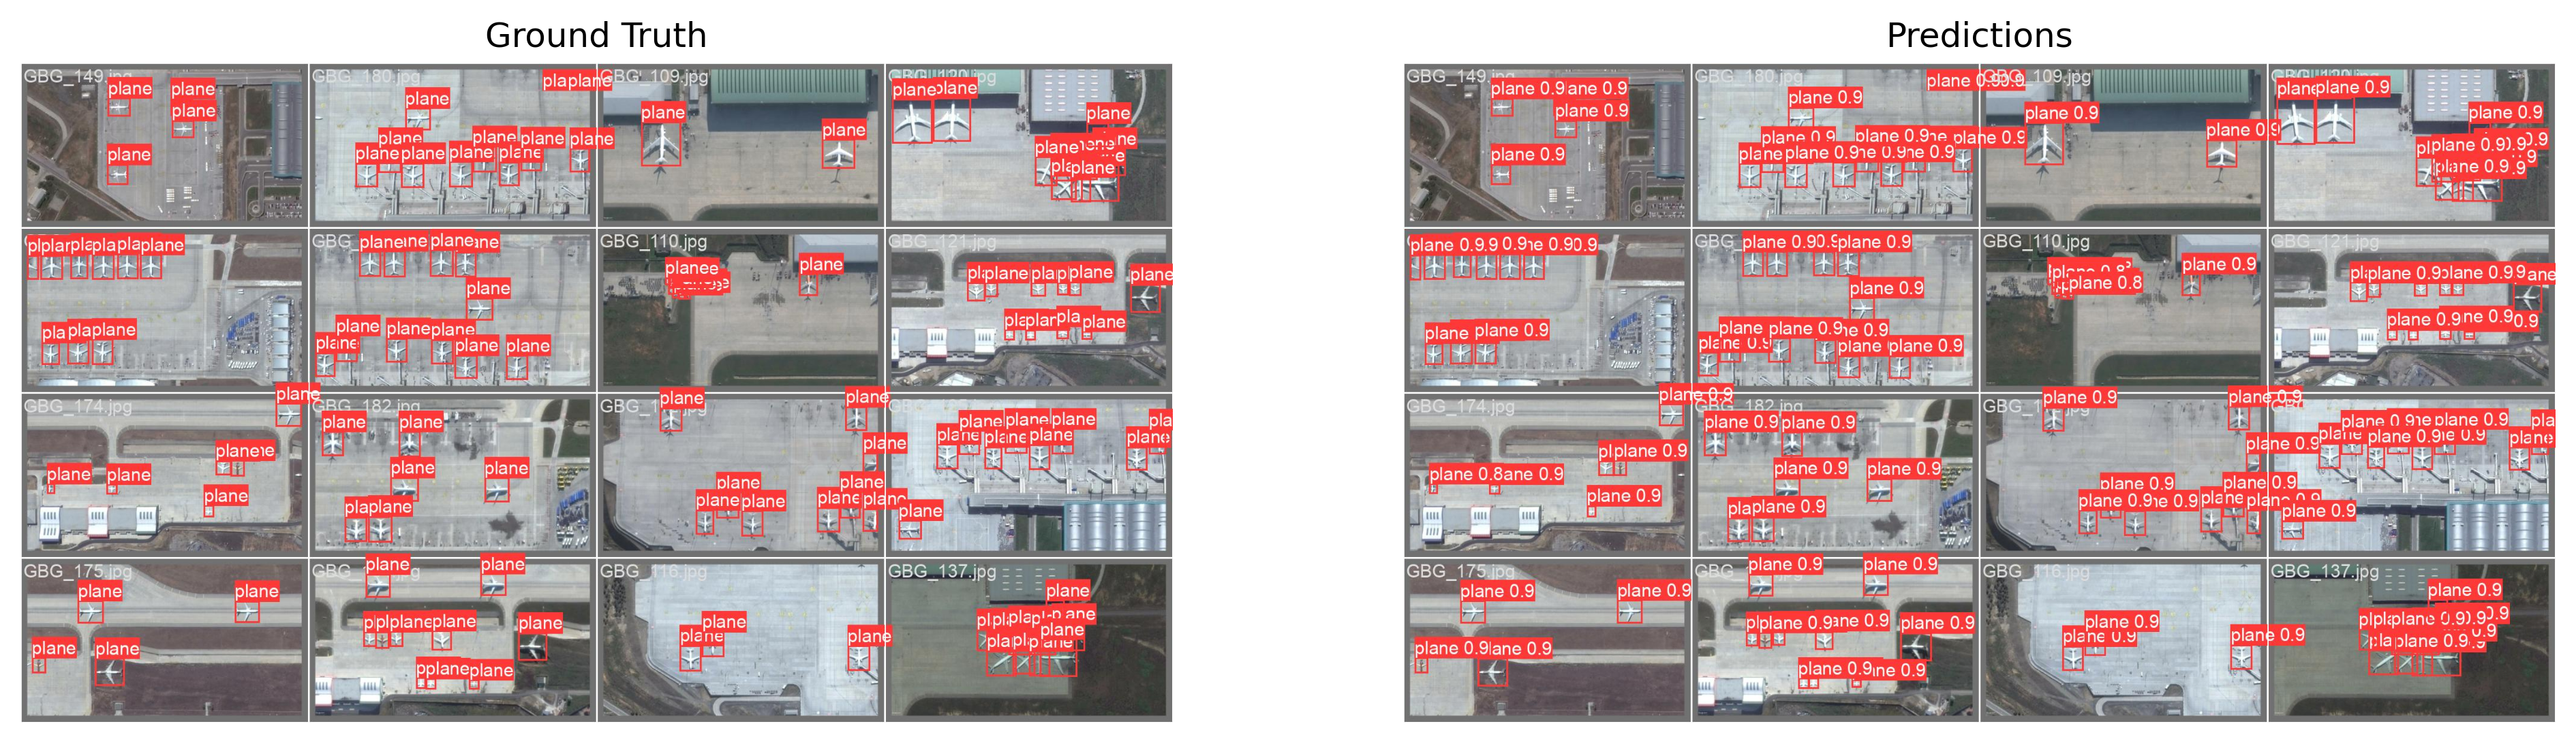

In [ ]:
image1 = mpimg.imread(f"{HOME}/yolov9/runs/train/exp/val_batch0_labels.jpg")
image2 = mpimg.imread(f"{HOME}/yolov9/runs/train/exp/val_batch0_pred.jpg")

fig, axes = plt.subplots(1, 2, figsize=(16, 9), dpi=300)
axes[0].imshow(image1)
axes[0].set_title('Ground Truth')
axes[0].axis('off')
axes[1].imshow(image2)
axes[1].set_title('Predictions')
axes[1].axis('off')
plt.savefig(f"{BASE_DIRECTORY}/outputs/label_pred.png")
plt.show()

## **3. Evaluate Model**

In [ ]:
%cd {HOME}/yolov9

!python val_dual.py \
--img 640 --batch 16 --save-txt \
--data /gdrive/MyDrive/Datasets/HRPlanes/YOLOV8/coco.yaml \
--weights {HOME}/yolov9/runs/train/exp/weights/best.pt

/content/yolov9
val_dual: data=/gdrive/MyDrive/Datasets/HRPlanes/YOLOV8/coco.yaml, weights=['/content/yolov9/runs/train/exp/weights/best.pt'], batch_size=16, imgsz=640, conf_thres=0.001, iou_thres=0.7, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=True, save_hybrid=False, save_conf=False, save_json=True, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False, min_items=0
YOLO 🚀 v0.1-89-g93f1a28 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
yolov9-e summary: 839 layers, 68547814 parameters, 0 gradients, 240.7 GFLOPs
val: Scanning /gdrive/MyDrive/Datasets/HRPlanes_ds/val/labels.cache... 620 images, 5 backgrounds, 0 corrupt: 100% 620/620 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 39/39 [00:32<00:00,  1.21it/s]
                   all        620       3290      0.992      0.992      0.994      0.899
Speed: 0.1ms 

## **4. Move Model Items into Google Drive**

In [ ]:
BASE_DIRECTORY

'/gdrive/MyDrive/Datasets/HRPlanes/YOLOV8/YOLOv9e/Experiment_No_58/'

Instead of uploading and downloading files, we can directly move them to the desired path.

In [ ]:
shutil.move(f"{HOME}/yolov9/runs/", BASE_DIRECTORY)

'/gdrive/MyDrive/Datasets/HRPlanes/YOLOV8/YOLOv9e/Experiment_No_58/runs'

In [ ]:
from datetime import datetime
print(f"Changes have been made to the project on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Changes have been made to the project on 2024-05-27 10:50:59
